In [1]:
!gdown 1YCAZY4xVH2IHvV1QzAb0Q12bC5HXGe-2

Downloading...
From: https://drive.google.com/uc?id=1YCAZY4xVH2IHvV1QzAb0Q12bC5HXGe-2
To: /content/digit-recognizer.zip
100% 16.1M/16.1M [00:00<00:00, 288MB/s]


In [2]:
 !unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [4]:
import warnings
# ignore all warnings
warnings.filterwarnings("ignore")

In [5]:
train_dataset = pd.read_csv('./train.csv', dtype=np.float32)
test_dataset  = pd.read_csv('./test.csv',dtype=np.float32 )

In [6]:
train_dataset.shape

(42000, 785)

In [7]:
train_dataset.shape

(42000, 785)

In [8]:
train_dataset[:3]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def preprocessing(train, test, split_train_size=0.2):
    targets = train.label.values
    features = train.drop(["label"], axis=1).values

    features = features / 255.

    X_train, X_val, y_train, y_val = train_test_split(features,targets,test_size=split_train_size,random_state=42)
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)


    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor)

    return X_train, y_train, X_val, y_val,

In [10]:
X_train, y_train, X_val, y_val, = preprocessing(train_dataset, test_dataset)

In [11]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape training labels: {y_train.shape}')
print(f'Shape of validation data: {X_val.shape}')
print(f'Shape of valiation labels: {y_val.shape}')

Shape of training data: torch.Size([33600, 784])
Shape training labels: torch.Size([33600])
Shape of validation data: torch.Size([8400, 784])
Shape of valiation labels: torch.Size([8400])


In [12]:
BATCH_SIZE = 100
N_ITER = 2500
EPOCHS = 15

In [13]:
train_tensor = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor = torch.utils.data.TensorDataset(X_val, y_val)

In [14]:
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_tensor, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
train_labels = next(iter(train_loader))
train_labels[0].shape

torch.Size([100, 784])

In [16]:
def display_images():
  plt.figure(figsize=(12,4))
  for i in range(3):
    index = random.randint(1,X_train.shape[0])
    label = y_train[index].numpy()
    plt.subplot(330 + 1 + i)
    plt.title('Label: %s \n' % label, fontsize=18)
    plt.imshow(X_train[index].resize(28, 28), cmap=plt.get_cmap('gray'))
plt.subplots_adjust(bottom=0.001)
plt.subplots_adjust(top=0.99)
plt.show()

<Figure size 432x288 with 0 Axes>

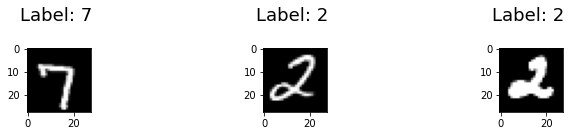

In [17]:
display_images()

In [18]:
from torch import nn

In [19]:
class CNNmodel(nn.Module):
    def __init__(self):
      super(CNNmodel, self).__init__()
      self.c1 = nn.Conv2d(in_channels= 1,out_channels = 16,kernel_size=(5,5),stride=[1],padding=0)
      self.r1 = nn.ReLU()
      self.m1 = nn.MaxPool2d(kernel_size=(2,2))
      self.d1 = nn.Dropout(0.25)

      self.c2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=[1],padding=0)
      self.r2 = nn.ReLU()
      self.m2 = nn.MaxPool2d(kernel_size=(2,2))
      self.d2 = nn.Dropout(0.25)

      self.fc1 = nn.Linear(32 * 5 * 5, 256)
      self.d3 = nn.Dropout(0.25)
      self.fc2 = nn.Linear(256, 10)
    def forward(self,x):
      out = self.c1(x) # [BATCH_SIZE, 16, 24, 24]
      out = self.r1(out)
      out = self.m1(out) # [BATCH_SIZE, 16, 12, 12]
      out = self.d1(out)

      out = self.c2(out) # [BATCH_SIZE, 32, 10, 10]
      out = self.r2(out)
      out = self.m2(out) # [BATCH_SIZE, 32, 5, 5]
      out = self.d2(out)

      out = out.view(out.size(0), -1)  # [BATCH_SIZE, 32*5*5=800]
      out = self.fc1(out) # [BATCH_SIZE, 256]
      out = self.d3(out)
      out = self.fc2(out) # [BATCH_SIZE, 10]
      return out


In [20]:
from torch.optim import lr_scheduler 

In [21]:
# Create CNN
model = CNNmodel()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# LR scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [22]:
print(model)

CNNmodel(
  (c1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1,))
  (r1): ReLU()
  (m1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (d1): Dropout(p=0.25, inplace=False)
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1,))
  (r2): ReLU()
  (m2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (d2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (d3): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [23]:
device = ''
if torch.cuda.is_available():
    print("Model will be training on GPU")
    model = model.cuda()
    criterion = criterion.cuda()
    device = 'cuda'
else:
  device = 'cpu'
  print("Model will be training on CPU")

Model will be training on GPU


In [24]:
def fit(epoch):
  print('Training ...')
  model.train()
  exp_lr_scheduler.step()
  train_loss = 0.0
  train_accuracy = 0

  # The current learning rate is stored in the
  #  variable train_lr using optimizer.param_groups[0]['lr'].
  #  This assumes that the optimizer being used has only one parameter group (e.g., if using Adam optimizer).
  train_lr = optimizer.param_groups[0]['lr']
  # A PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph.
  # If x is a Variable then x.data is a Tensor giving its value, 
  # and x.grad is another Variable holding the gradient of x with respect to some scalar value.
  for batch_index, (data,target) in enumerate(train_loader):
    data = data.to(device)
    target = target.type(torch.LongTensor)
    target = target.to(device)
    data, target = Variable(data.view(BATCH_SIZE, 1, 28, 28)), Variable(target)

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)

    train_loss += loss.item()
    # finding max
    _, preds = torch.max(output.data, 1)
    train_accuracy += (preds == target).sum().item()

    loss.backward()
    optimizer.step()

    if (batch_index + 1) % 50 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1,
                (batch_index + 1) * len(data),
                len(train_loader.dataset),
                BATCH_SIZE * (batch_index + 1) / len(train_loader),
                loss.cpu().detach().numpy()))
        
  train_total_loss = train_loss / len(train_loader.dataset)
  train_total_accuracy = 100. * train_accuracy / len(train_loader.dataset)

  return train_total_loss, train_total_accuracy, train_lr
      


In [25]:
def validate(data_loader):
    print('validating .... ')

    model.eval()
    val_preds = torch.LongTensor()
    val_prob = torch.FloatTensor()

    val_loss = 0.0
    val_acc = 0

    for data, target in data_loader:
        data = data.float().to(device)
        target = target.to(device)
        data, target = Variable(data.view(BATCH_SIZE, 1, 28, 28), volatile=True), Variable(target)

        output = model(data.view(BATCH_SIZE, 1, 28, 28))
        loss = criterion(output, target)

        val_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        prob = torch.nn.functional.softmax(output.data)

        val_acc += pred.eq(target.data.view_as(pred)).cpu().sum()

        val_preds = torch.cat((val_preds.to(device), pred.to(device)), dim=0)
        val_prob = torch.cat((val_prob.to(device), prob.to(device)))

    val_output_loss = val_loss / len(data_loader.dataset)
    val_output_acc = 100. * val_acc / len(data_loader.dataset)

    return val_output_loss, val_output_acc, val_preds, val_prob



In [26]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
val_preds, val_probs = [], []
train_lr = []

In [27]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} of {EPOCHS}\n")
    train_epoch_loss, train_epoch_accuracy, train_epoch_lr = fit(epoch)
    val_epoch_loss, val_epoch_accuracy, val_epoch_preds, val_epoch_probs = validate(val_loader)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_lr.append(train_epoch_lr)

    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_preds.append(val_epoch_preds)
    val_probs.append(val_epoch_probs)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}\n')

Epoch 1 of 15

Training ...
Train Epoch: 1 [5000/33600 (15%)]	Loss: 0.312499
Train Epoch: 1 [10000/33600 (30%)]	Loss: 0.090381
Train Epoch: 1 [15000/33600 (45%)]	Loss: 0.118412
Train Epoch: 1 [20000/33600 (60%)]	Loss: 0.095001
Train Epoch: 1 [25000/33600 (74%)]	Loss: 0.097954
Train Epoch: 1 [30000/33600 (89%)]	Loss: 0.020750
validating .... 
Train Loss: 0.0026, Train Acc: 91.99
Val Loss: 0.0009, Val Acc: 97.15

Epoch 2 of 15

Training ...
Train Epoch: 2 [5000/33600 (15%)]	Loss: 0.085472
Train Epoch: 2 [10000/33600 (30%)]	Loss: 0.251313
Train Epoch: 2 [15000/33600 (45%)]	Loss: 0.095659
Train Epoch: 2 [20000/33600 (60%)]	Loss: 0.023568
Train Epoch: 2 [25000/33600 (74%)]	Loss: 0.086614
Train Epoch: 2 [30000/33600 (89%)]	Loss: 0.035035
validating .... 
Train Loss: 0.0010, Train Acc: 96.69
Val Loss: 0.0007, Val Acc: 97.90

Epoch 3 of 15

Training ...
Train Epoch: 3 [5000/33600 (15%)]	Loss: 0.066582
Train Epoch: 3 [10000/33600 (30%)]	Loss: 0.154735
Train Epoch: 3 [15000/33600 (45%)]	Loss: 0.

In [28]:
torch.save({'epoch': EPOCHS,'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'loss': criterion, },'./model.pth')
# load the model checkpoint
checkpoint = torch.load('./model.pth')
print(f"Trained for {EPOCHS} number of epochs.")

Trained for 15 number of epochs.


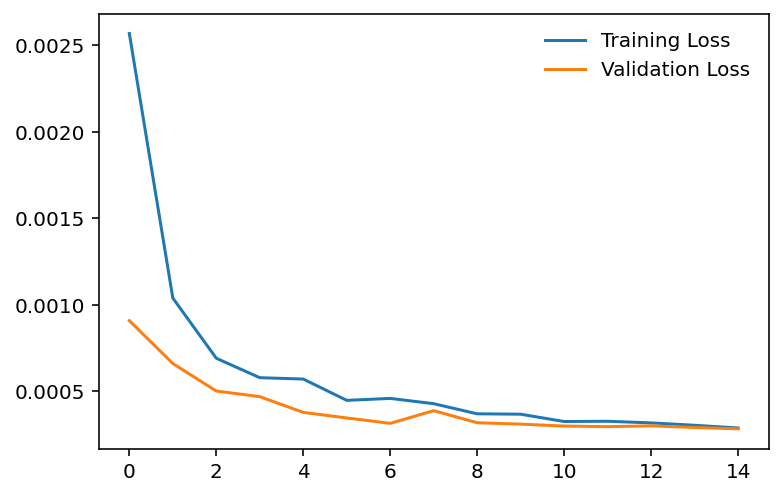

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(frameon=False)

In [30]:
y_pred_classes = val_preds[EPOCHS - 1].cpu().numpy().ravel()

In [31]:
def display_pred_images():
    plt.figure(figsize=(12, 4))
    for i in range(3):
        index = random.randint(1, X_val.shape[0])
        predicted_label = y_pred_classes[index]
        true_label = y_val[index]
        plt.subplot(330 + 1 + i)
        plt.title('Predicted label: %s \n' % predicted_label + \
                  'True label %s \n' % true_label.item(),
                  fontsize=18)
        plt.imshow(X_val[index].view(28, 28), cmap=plt.get_cmap('gray'))
    plt.subplots_adjust(bottom=0.001)
    plt.subplots_adjust(top=0.99)
    plt.show()

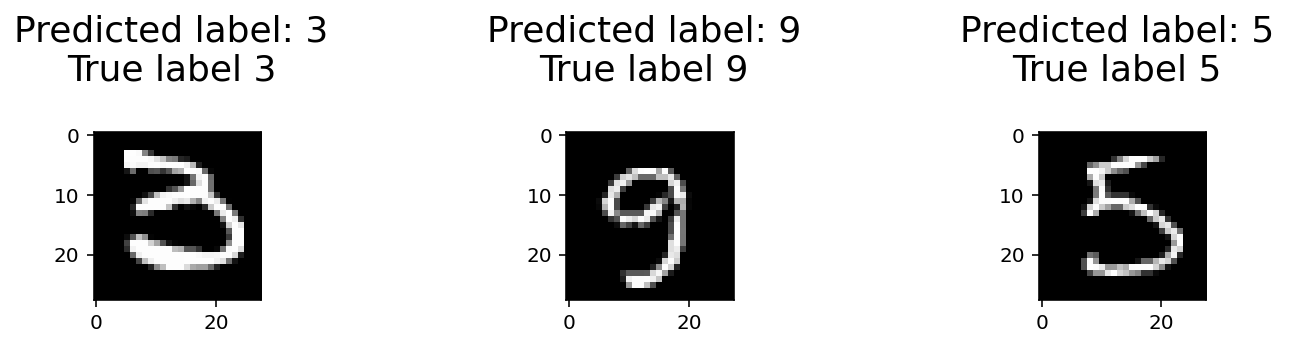

In [32]:
display_pred_images()